In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

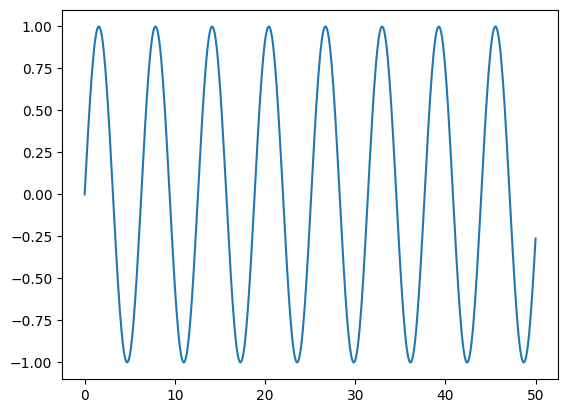

In [260]:
# Création de notre sinusoïde avec Numpy
x = np.linspace(0, 50, 501)
y = np.sin(x)
plt.plot(x, y)

In [261]:
# Transform the sin array into a DataFrame
df = pd.DataFrame(data=y,index=x,columns=['Sinus'])
print(df.shape)
df.head()

(501, 1)


,Sinus
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


## Répartition Train / Test

Note ! C'est très différent de notre méthodologie habituelle de répartition Entraînement / Test !

In [262]:
df.shape

(501, 1)

In [263]:
test_percent = 0.1
test_point = np.round(len(df) * test_percent)
test_ind = int(len(df) - test_point)

In [264]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
print(train.shape)
print(test.shape)
test.head()

(451, 1)
(50, 1)


,Sinus
45.1,0.899097
45.2,0.938307
45.3,0.968142
45.4,0.988304
45.5,0.998591


## Normalisation

In [265]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Création des données d'entraînement

In [266]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

"""
- `data` : Ceci est la série temporelle, ici c'est correspond à l'axe des x (soit `x`).
- `targets` : Ceci est la série temporelle que nous voulons prédire, ici c'est correspond à l'axe des y (soit `sin`).
- `length` : C'est la longueur de la séquence temporelle que nous voulons pour un seul lot. Par exemple, si nos séries temporelles sont des données de temps quotidien et que nous voulons prédire les données du jour suivant en utilisant les 30 jours précédents, alors la longueur serait 30.	
- `batch_size` : Ceci est la taille de la sortie des lots. Par exemple, si `length` est 30 (c'est-à-dire 30 jours) et que nous voulons prédire la valeur du jour suivant, alors nous pouvons définir `batch_size` sur 1 et la sortie de chaque lot sera un seul point de données. Nous pouvons également définir `batch_size` sur 10, de sorte que chaque lot de sortie soit de 10 points de données.
"""

length = 2 # Il faut choisir un nombre assez grand pour que le modèle puisse apprendre les tendances. Cependant, il ne faut pas choisir un nombre trop grand car le modèle sera trop lent à s'entraîner.
batch_size = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [267]:
# Ceci un exemple pour un length de 2 et un batch_size de 1 à titre d'illustration uniquement :
print(f"len(generator): {len(generator)} | len(scaled_train): {len(scaled_train)}") # différence de 2 car on a pris les 2 premiers points pour créer la première séquence temporelle de length 2
X,y = generator[0]
print(f'X:{X}')
print(f'y:{y}')
print("------------------")
print(scaled_train[:5])
print("------------------")
print(scaled_train[2])
# ici on a pris les 2 premiers points pour créer la première séquence temporelle de length 2 pour prédire le 3ème point (y)

len(generator): 449 | len(scaled_train): 451
X:[[[0.49999912]
  [0.54991622]]]
y:[[0.59933458]]
------------------
[[0.49999912]
 [0.54991622]
 [0.59933458]
 [0.64776041]
 [0.69470985]]
------------------
[0.59933458]


In [268]:
length = 50 # Longueur des séquences de sortie (en nombre de pas temporel)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Création du modèle RNN simple

In [269]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN

In [270]:
n_features = 1

# définir le modèle
model = Sequential()

# Couche simple RNN
model.add(SimpleRNN(50,input_shape=(length, n_features)))

# Prédiction finale
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [271]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [272]:
model.fit(generator, epochs=5)

Epoch 1/5


401/401 [==============================] - 3s 6ms/step - loss: 0.0099
Epoch 2/5
401/401 [==============================] - 2s 5ms/step - loss: 1.2175e-04
Epoch 3/5
401/401 [==============================] - 4s 9ms/step - loss: 5.9137e-05
Epoch 4/5
401/401 [==============================] - 3s 8ms/step - loss: 5.6249e-05
Epoch 5/5
401/401 [==============================] - 3s 6ms/step - loss: 5.2812e-04


## évaluation du modèle

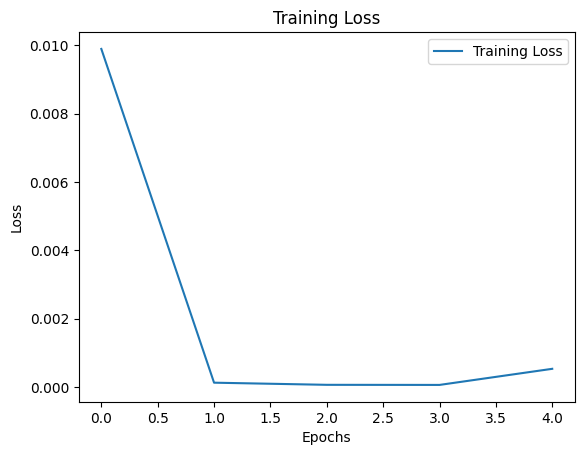

In [273]:
loss = model.history.history['loss']
epochs = range(len(loss))

plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


## Prédiction sur les données de test

In [274]:
first_eval_batch = scaled_train[-length:] # On prend les 50 derniers points de la série temporelle pour prédire le point suivant
first_eval_batch = first_eval_batch.reshape((1, length, n_features)) # On reshape pour que le modèle puisse prédire sur un batch de 1 point
model.predict(first_eval_batch)

1/1 [==============================] - 0s 199ms/step


array([[0.9588583]], dtype=float32)

In [275]:
scaled_test[0] # Valeur réelle du point que l'on veut prédire
# la valeur prédite est très proche de la valeur réelle donc le modèle semble fonctionner

array([0.94955134])

In [276]:
test_predictions = []
first_eval_batch = scaled_train[-length:] # On prend les 50 derniers points du set d'entraînement pour prédire le point suivant
current_batch = first_eval_batch.reshape((1, length, n_features)) # On reshape pour que le modèle puisse prédire sur un batch de 1 point
np.set_printoptions(suppress=True)
print(current_batch.shape)
print(current_batch.flatten()) # voir les valeurs du batch de départ

(1, 50, 1)
[0.83740582 0.7988817  0.75737124 0.7132892  0.66707605 0.61919351
 0.57012002 0.52034591 0.4703685  0.42068715 0.37179825 0.3241903
 0.27833897 0.2347024  0.19371658 0.15579104 0.12130471 0.09060217
 0.06399019 0.04173466 0.02405797 0.01113672 0.00310002 0.00002817
 0.00195187 0.00885189 0.02065929 0.0372561  0.05847648 0.08410841
 0.11389578 0.14754097 0.1847078  0.22502492 0.2680895  0.31347123
 0.3607167  0.40935382 0.45889664 0.50885015 0.55871522 0.60799362
 0.65619297 0.70283168 0.74744376 0.78958345 0.82882972 0.86479041
 0.89710623 0.92545429]


In [277]:
for i in range(len(test)):
    # On prédit un point
    current_pred = model.predict(current_batch)[0]

    # On stocke cette prédiction
    test_predictions.append(current_pred) 
    
    # On met à jour le batch pour prédire le point suivant en enlevant le premier point et en ajoutant la prédiction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

print(len(test_predictions))

1/1 [==============================] - 0s 26ms/step
50


In [278]:
true_predictions = scaler.inverse_transform(test_predictions) # mes vraies prédictions
test["Predictions RNN"] = true_predictions # on ajoute les prédictions à notre dataframe test
test # comparaison des vraies valeurs avec les prédictions

C:\Users\hajdaini\AppData\Local\Temp\ipykernel_3036\3481777600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predictions RNN"] = true_predictions # on ajoute les prédictions à notre dataframe test


,Sinus,Predictions RNN
45.1,0.899097,0.917711
45.2,0.938307,0.953210
45.3,0.968142,0.990935
45.4,0.988304,1.013882
45.5,0.998591,1.035121
45.6,0.998900,1.029150
45.7,0.989229,1.030614
45.8,0.969673,1.006697
45.9,0.940429,0.984447
46.0,0.901788,0.941941


<Axes: >

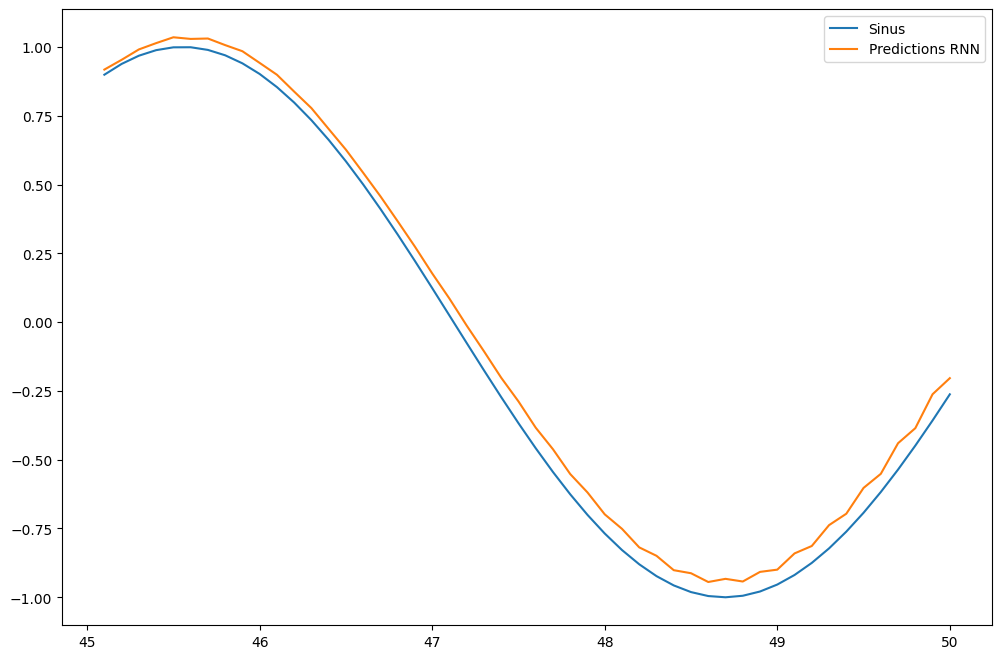

In [279]:
test.plot(figsize=(12,8))

C'est normal que les prédictions vers la fin soient mauvaises, car les nouvelles entrées sont eux aussi basées sur les prédictions précédentes, qui se sont avérées fausses.

Utilisons maintenant un modèle LSTM pour essayer d'améliorer les résultats !

## Création du modèle LSTM

In [280]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [281]:
scaled_test.shape

(50, 1)

In [282]:
length = 50 - 1 # length doit toujours être inférieur à la taille du set de test
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1) # cette fois on utilise le set de test pour la validation

In [283]:
model = Sequential()
model.add(LSTM(50,input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [284]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [285]:
model.fit(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20
402/402 [==============================] - 8s 15ms/step - loss: 0.0151 - val_loss: 1.6055e-04
Epoch 2/20
402/402 [==============================] - 6s 14ms/step - loss: 1.8846e-04 - val_loss: 4.1847e-05
Epoch 3/20
402/402 [==============================] - 6s 14ms/step - loss: 1.5639e-04 - val_loss: 2.3431e-04
Epoch 4/20
402/402 [==============================] - 5s 13ms/step - loss: 3.1210e-04 - val_loss: 1.0245e-04


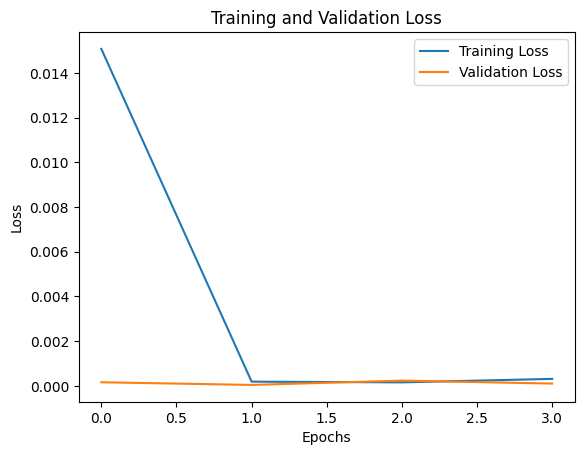

In [286]:
# graphique de l'erreur
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [287]:
test_predictions = []
first_eval_batch = scaled_train[-length:] # On prend les 50 derniers points du set d'entraînement pour prédire le point suivant
current_batch = first_eval_batch.reshape((1, length, n_features)) # On reshape pour que le modèle puisse prédire sur un batch de 1 point
for i in range(len(test)):
    # On prédit un point
    current_pred = model.predict(current_batch)[0]

    # On stocke cette prédiction
    test_predictions.append(current_pred) 
    
    # On met à jour le batch pour prédire le point suivant en enlevant le premier point et en ajoutant la prédiction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

print(len(test_predictions))

1/1 [==============================] - 0s 31ms/step
50


In [288]:
true_predictions = scaler.inverse_transform(test_predictions) # mes vraies prédictions
test["LSTM Predictions"] = true_predictions # on ajoute les prédictions à notre dataframe test
test # comparaison des vraies valeurs avec les prédictions

C:\Users\hajdaini\AppData\Local\Temp\ipykernel_3036\3243995658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["LSTM Predictions"] = true_predictions # on ajoute les prédictions à notre dataframe test


,Sinus,Predictions RNN,LSTM Predictions
45.1,0.899097,0.917711,0.900755
45.2,0.938307,0.953210,0.936884
45.3,0.968142,0.990935,0.963100
45.4,0.988304,1.013882,0.979207
45.5,0.998591,1.035121,0.985206
45.6,0.998900,1.029150,0.981213
45.7,0.989229,1.030614,0.967439
45.8,0.969673,1.006697,0.944176
45.9,0.940429,0.984447,0.911780
46.0,0.901788,0.941941,0.870662


<Axes: >

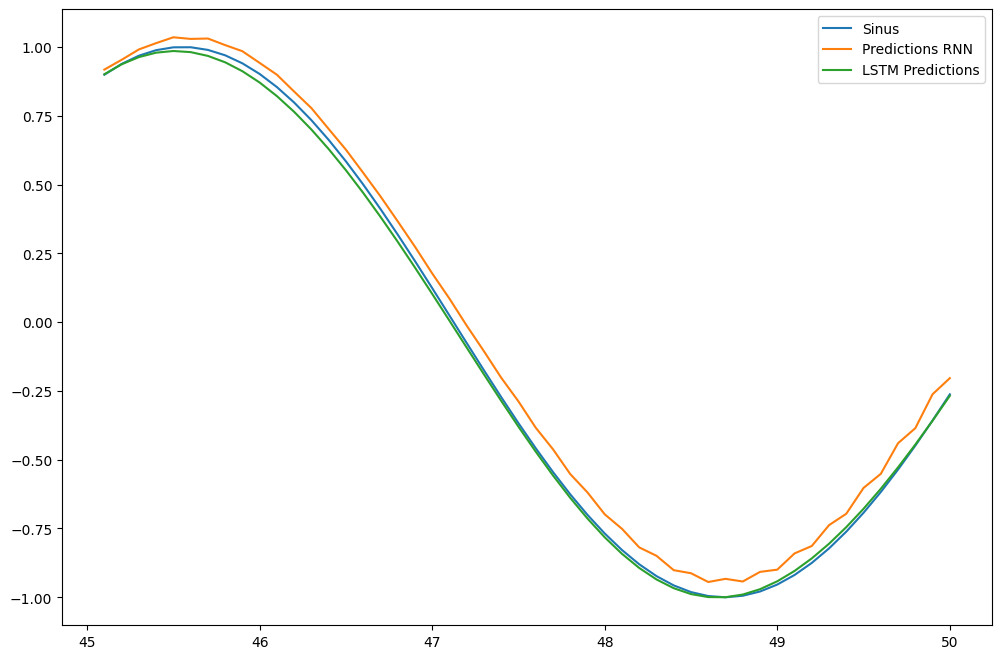

In [289]:
test.plot(figsize=(12,8))

## Prédiction sur de futures données inconnues

In [290]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [291]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [292]:
model = Sequential()
model.add(LSTM(50,input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10400     
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [293]:
model.fit(generator,epochs=6) # meme nombre d'epochs que pour le modèle précédent

Epoch 1/6
452/452 [==============================] - 8s 13ms/step - loss: 0.0086
Epoch 2/6
452/452 [==============================] - 6s 13ms/step - loss: 1.0510e-04
Epoch 3/6
452/452 [==============================] - 6s 13ms/step - loss: 2.2320e-04
Epoch 4/6
452/452 [==============================] - 6s 14ms/step - loss: 7.1143e-05
Epoch 5/6
452/452 [==============================] - 6s 13ms/step - loss: 4.9105e-05
Epoch 6/6
452/452 [==============================] - 7s 14ms/step - loss: 1.6497e-04


In [300]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    forecast.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
print(len(forecast))

1/1 [==============================] - 0s 35ms/step
50


In [301]:
forecast = scaler.inverse_transform(forecast)
forecast_index = np.arange(50.1,55.1,step=0.1) # afin que x correspond bien avec les valeurs y de la prédiction
print(forecast_index.shape)
print(forecast.shape)

(50,)
(50, 1)


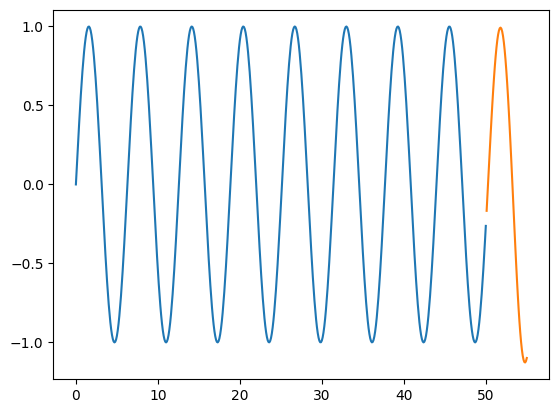

In [302]:
plt.plot(df.index,df['Sinus'])
plt.plot(forecast_index,forecast) # prédiction